In [ ]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[0]) >= 2, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 16, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")


torch version: 2.1.0+cu121
torchvision version: 0.16.0+cu121


In [ ]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mahireddy1318/udemy_pytorch_tutorials.git
    !mv udemy_pytorch_tutorials/going_modular .
    #!mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf udemy_pytorch_tutorials
    from going_modular import data_setup, engine
    from going_modular.helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'udemy_pytorch_tutorials'...
remote: Enumerating objects: 334, done.
remote: Counting objects: 100% (334/334), done.
remote: Compressing objects: 100% (333/333), done.
remote: Total 334 (delta 4), reused 324 (delta 1), pack-reused 0
Receiving objects: 100% (334/334), 34.00 MiB | 7.30 MiB/s, done.
Resolving deltas: 100% (4/4), done.
mv: cannot move 'udemy_pytorch_tutorials/going_modular' to './going_modular': Directory not empty


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## 1. Getting data

In [ ]:
# Download pizza, steak, sushi images from GitHub
data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

data_20_percent_path

[INFO] data/pizza_steak_sushi_20_percent directory exists, skipping download.


PosixPath('data/pizza_steak_sushi_20_percent')

In [ ]:
import glob
import os

for f in os.listdir('/content/data/pizza_steak_sushi_20_percent/test'):
  print(f)



pizza
steak
sushi


In [ ]:
a = list(data_20_percent_path.glob('*/*/*'))
len(a)

600

In [ ]:
print(sum(1 for _ in data_20_percent_path.glob('*/*/*')))

600


In [ ]:
def walk_through_dir(dir_path):
    """
    Walks through dir_path returning its contents.
    Args:
    dir_path (str): target directory

    Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
    """
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")



In [ ]:
walk_through_dir('/content/data/pizza_steak_sushi_20_percent')

There are 2 directories and 0 images in '/content/data/pizza_steak_sushi_20_percent'.
There are 3 directories and 0 images in '/content/data/pizza_steak_sushi_20_percent/test'.
There are 0 directories and 46 images in '/content/data/pizza_steak_sushi_20_percent/test/pizza'.
There are 0 directories and 58 images in '/content/data/pizza_steak_sushi_20_percent/test/steak'.
There are 0 directories and 46 images in '/content/data/pizza_steak_sushi_20_percent/test/sushi'.
There are 3 directories and 0 images in '/content/data/pizza_steak_sushi_20_percent/train'.
There are 0 directories and 154 images in '/content/data/pizza_steak_sushi_20_percent/train/pizza'.
There are 0 directories and 146 images in '/content/data/pizza_steak_sushi_20_percent/train/steak'.
There are 0 directories and 150 images in '/content/data/pizza_steak_sushi_20_percent/train/sushi'.


In [ ]:
train_dir = data_20_percent_path / 'train'
test_dir = data_20_percent_path / 'test'

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/test'))

## 2. FoodVision Mini model deployment experiment outline
So our goals are:

Performance - A model that performs at 95%+ accuracy.

Speed - A model that can classify an image at ~30FPS (0.03 seconds inference time per image, also known as latency).

To try and achieve these results, let's bring in our best performing models from the previous sections:

**EffNetB2 feature extractor (EffNetB2 for short)** - originally created in 07. PyTorch Experiment Tracking section 7.5 using torchvision.models.efficientnet_b2() with adjusted classifier layers.

**ViT-B/16 feature extractor (ViT for short)**\ - originally created in 08. PyTorch Paper Replicating section 10 using torchvision.models.vit_b_16() with adjusted head layers.
Note ViT-B/16 stands for "Vision Transformer Base, patch size 16"

## 3. Creating an EffNetB2 feature extractor

In [ ]:
from torchvision import models

EffNetB1_weights = models.EfficientNet_B1_Weights.DEFAULT
#print(EffNetB2_weights)
EffNetB1 = models.efficientnet_b1(weights= EffNetB1_weights)

In [ ]:
for param in EffNetB1.parameters():
  param.requires_grad = False


In [ ]:
EffNetB1.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace = True),
    nn.Linear(in_features= 1280, out_features= 3, device= device)
)

In [ ]:
EffNetB1

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [ ]:
def create_effnetb1_model(num_classes:int=3,
                          seed:int=42):
    """Creates an EfficientNetB2 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of classes in the classifier head.
            Defaults to 3.
        seed (int, optional): random seed value. Defaults to 42.

    Returns:
        model (torch.nn.Module): EffNetB2 feature extractor model.
        transforms (torchvision.transforms): EffNetB2 image transforms.
    """
    # 1, 2, 3. Create EffNetB2 pretrained weights, transforms and model

    EffNetB1_weights = models.EfficientNet_B1_Weights.DEFAULT
    #print(EffNetB1_weights)
    transforms = EffNetB1_weights.transforms()
    model = models.efficientnet_b1(weights= EffNetB1_weights)

    # 4. Freeze all layers in base model
    for param in model.parameters():
        param.requires_grad = False

    # 5. Change classifier head with random seed for reproducibility
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1280, out_features=num_classes),
    )

    return model, transforms

In [ ]:
effnetb1, effnetb1_transforms = create_effnetb1_model(num_classes=3, seed=42)


In [ ]:
from torchinfo import summary

summary(model = effnetb1,
        input_size= (1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

### 3.2 Creating DataLoaders for EffNetB1


---



In [ ]:
from going_modular import data_setup
import os
NUM_WORKERS = os.cpu_count()
print(f'NUM_WORKERS : {NUM_WORKERS}')
train_dataloader_effnetb1, test_dataloader_effnetb1, class_names = data_setup.create_dataloaders(
    train_dir = train_dir,
    test_dir = test_dir,
    transform = effnetb1_transforms,
    batch_size = 32,
    num_workers = NUM_WORKERS
)

train_dataloader_effnetb1, test_dataloader_effnetb1, class_names

NUM_WORKERS : 2


(<torch.utils.data.dataloader.DataLoader at 0x78aa10a3b7c0>,
 ['pizza', 'steak', 'sushi'])

## 3.3 Training EffNetB2 feature extractor

In [ ]:
from going_modular import engine

optimizer = torch.optim.Adam(params=effnetb1.parameters(),
                             lr=1e-3)

loss_fn = torch.nn.CrossEntropyLoss()

set_seeds()
effnetb1_results = engine.train(model=effnetb1,
                                train_dataloader=train_dataloader_effnetb1,
                                test_dataloader=test_dataloader_effnetb1,
                                epochs=10,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9992 | train_acc: 0.6521 | test_loss: 0.8609 | test_acc: 0.9040
Epoch: 2 | train_loss: 0.8055 | train_acc: 0.8375 | test_loss: 0.7284 | test_acc: 0.9006
Epoch: 3 | train_loss: 0.6933 | train_acc: 0.8708 | test_loss: 0.6373 | test_acc: 0.9102
Epoch: 4 | train_loss: 0.5686 | train_acc: 0.9146 | test_loss: 0.5657 | test_acc: 0.9284
Epoch: 5 | train_loss: 0.5144 | train_acc: 0.9083 | test_loss: 0.5000 | test_acc: 0.9347
Epoch: 6 | train_loss: 0.4882 | train_acc: 0.9021 | test_loss: 0.4523 | test_acc: 0.9381
Epoch: 7 | train_loss: 0.5190 | train_acc: 0.8729 | test_loss: 0.4188 | test_acc: 0.9534
Epoch: 8 | train_loss: 0.4644 | train_acc: 0.8625 | test_loss: 0.4007 | test_acc: 0.9659
Epoch: 9 | train_loss: 0.3813 | train_acc: 0.9125 | test_loss: 0.3829 | test_acc: 0.9534
Epoch: 10 | train_loss: 0.3973 | train_acc: 0.9167 | test_loss: 0.3725 | test_acc: 0.9443


### 3.4 Inspecting EffNetB2 loss curves

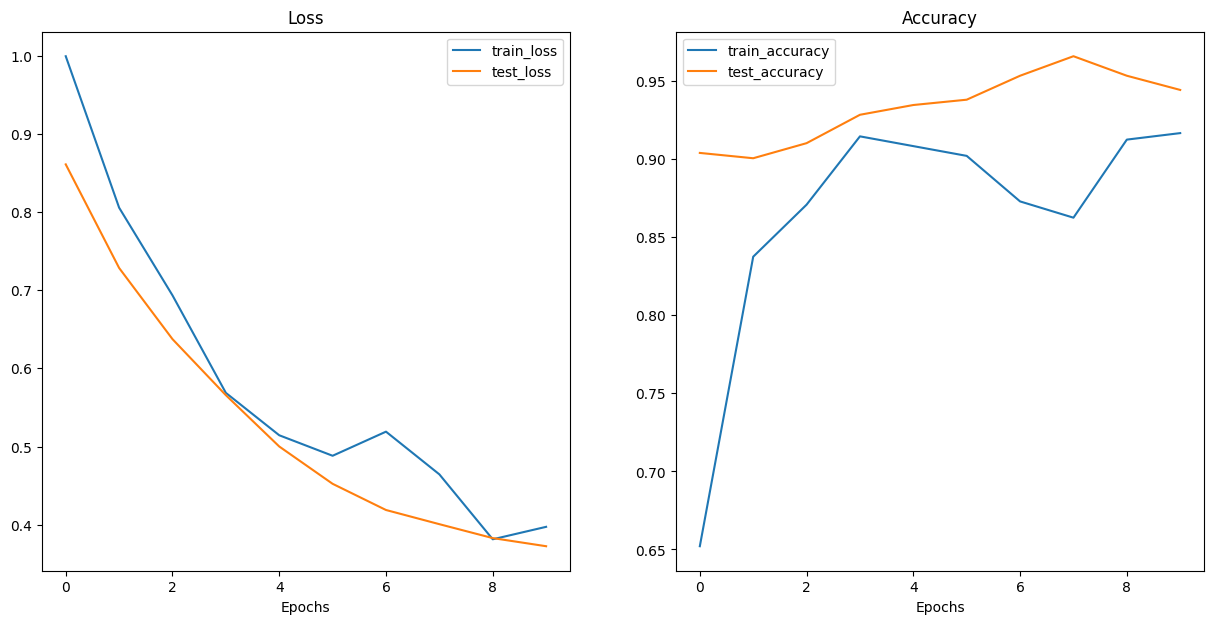

In [ ]:
from going_modular import helper_functions

helper_functions.plot_loss_curves(effnetb1_results)

### 3.5 Saving EffNetB1 feature extractor



In [ ]:
from going_modular import utils

utils.save_model(model = effnetb1,
                 target_dir = 'models',
                 model_name = '09_pretrained_effnetb1_feature_extractor_pizza_steak_sushi_20_percent.pth')

[INFO] Saving model to: models/09_pretrained_effnetb1_feature_extractor_pizza_steak_sushi_20_percent.pth


### 3.6 Checking the size of EffNetB2 feature extractor

In [ ]:
from pathlib import Path

pretrained_effnetb1_model_size = Path('/content/models/09_pretrained_effnetb1_feature_extractor_pizza_steak_sushi_20_percent.pth').stat().st_size // (1024 * 1024)
print(f"Pretrained EffNetB1 feature extractor model size: {pretrained_effnetb1_model_size} MB")

Pretrained EffNetB1 feature extractor model size: 25 MB


### 3.7 Collecting EffNetB2 feature extractor stats

In [ ]:
# Count number of parameters in EffNetB2
effnetb1_total_params = sum(torch.numel(param) for param in effnetb1.parameters())
effnetb1_total_params

6517027

In [ ]:
# Create a dictionary with EffNetB2 statistics
effnetb1_stats = {"test_loss": effnetb1_results["test_loss"][-1],
                  "test_acc": effnetb1_results["test_acc"][-1],
                  "number_of_parameters": effnetb1_total_params,
                  "model_size (MB)": pretrained_effnetb1_model_size}
effnetb1_stats

{'test_loss': 0.37245881259441377,
 'test_acc': 0.9443181818181818,
 'number_of_parameters': 6517027,
 'model_size (MB)': 25}

## 4. Creating a ViT feature extractor

In [ ]:
vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT
vit_weights

ViT_B_16_Weights.IMAGENET1K_V1

In [ ]:
vit_transforms = vit_weights.transforms()
vit_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [ ]:
# Check out ViT heads layer
vit = torchvision.models.vit_b_16()
vit.heads

Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)

In [ ]:
def create_vit_b_16_model(num_classes : int =3,
                          seed : int = 42):
  vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

  vit_transforms = vit_transforms = vit_weights.transforms()

  model = torchvision.models.vit_b_16(weights = vit_weights)

  torch.manual_seed(seed)
  for param in model.parameters():
    param.requires_grad = False

  model.heads = nn.Linear(
      in_features= 768,
      out_features= num_classes
  )

  return model, transforms


In [ ]:
vit, transforms = create_vit_b_16_model(
    num_classes=3,
    seed=42
)

In [ ]:
from torchinfo import summary
summary(
    model = vit,
    input_size=(1, 3, 224, 224),
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

In [ ]:
from going_modular import data_setup
train_dataloader_vit, test_dataloader_vit, class_names = data_setup.create_dataloaders(
    train_dir = train_dir,
    test_dir = test_dir,
    transform = vit_transforms,
    batch_size = 32,
    num_workers = NUM_WORKERS
)
train_dataloader_vit, test_dataloader_vit, class_names

(<torch.utils.data.dataloader.DataLoader at 0x78aa1d35e4d0>,
 ['pizza', 'steak', 'sushi'])

In [ ]:
from going_modular import engine

optimizer = torch.optim.Adam(vit.parameters(),
                             lr=1e-3
                             )

loss_fn = torch.nn.CrossEntropyLoss()

vit_results = engine.train(model = vit,
                           train_dataloader = train_dataloader_vit,
                           test_dataloader = test_dataloader_vit,
                           optimizer = optimizer,
                           loss_fn = loss_fn,
                           epochs = 10,
                           device = device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.6173 | train_acc: 0.7854 | test_loss: 0.2692 | test_acc: 0.9352
Epoch: 2 | train_loss: 0.2241 | train_acc: 0.9437 | test_loss: 0.1414 | test_acc: 0.9631
Epoch: 3 | train_loss: 0.1539 | train_acc: 0.9563 | test_loss: 0.1071 | test_acc: 0.9722
Epoch: 4 | train_loss: 0.1412 | train_acc: 0.9625 | test_loss: 0.0966 | test_acc: 0.9693
Epoch: 5 | train_loss: 0.1058 | train_acc: 0.9667 | test_loss: 0.0866 | test_acc: 0.9722
Epoch: 6 | train_loss: 0.0903 | train_acc: 0.9729 | test_loss: 0.0823 | test_acc: 0.9722
Epoch: 7 | train_loss: 0.0783 | train_acc: 0.9792 | test_loss: 0.0772 | test_acc: 0.9784
Epoch: 8 | train_loss: 0.0693 | train_acc: 0.9792 | test_loss: 0.0712 | test_acc: 0.9784
Epoch: 9 | train_loss: 0.0615 | train_acc: 0.9896 | test_loss: 0.0705 | test_acc: 0.9722
Epoch: 10 | train_loss: 0.0548 | train_acc: 0.9938 | test_loss: 0.0667 | test_acc: 0.9722


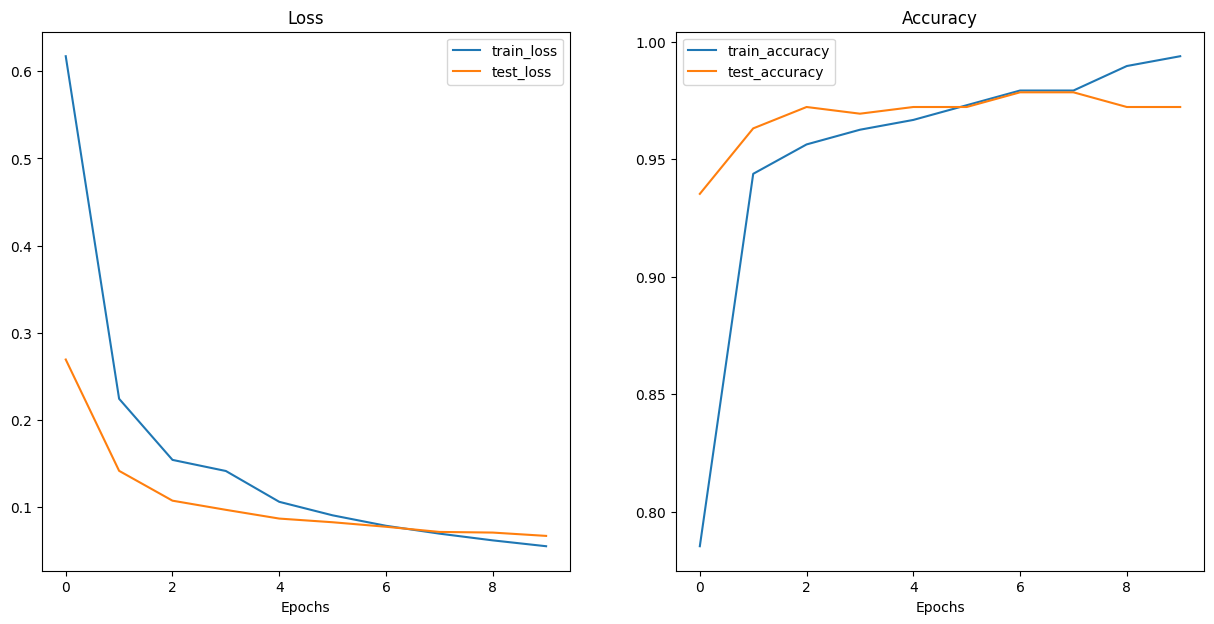

In [ ]:
from going_modular import helper_functions

helper_functions.plot_loss_curves(vit_results)

In [ ]:
from going_modular import utils

utils.save_model(model = vit,
                 target_dir = 'models',
                 model_name = '09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth')

[INFO] Saving model to: models/09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth


In [ ]:
from pathlib import Path

pretrained_vit_model_size = Path('/content/models/09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth').stat().st_size // (1024 * 1024)
print(f"Pretrained EffNetB1 feature extractor model size: {pretrained_vit_model_size} MB")

Pretrained EffNetB1 feature extractor model size: 327 MB


In [ ]:
# Count number of parameters in EffNetB2
vit_total_params = sum(torch.numel(param) for param in vit.parameters())
vit_total_params

85800963

In [ ]:
# Create a dictionary with EffNetB2 statistics
vit_stats = {"test_loss": vit_results["test_loss"][-1],
                  "test_acc": vit_results["test_acc"][-1],
                  "number_of_parameters": vit_total_params,
                  "model_size (MB)": pretrained_vit_model_size}
vit_stats

{'test_loss': 0.06667962307110428,
 'test_acc': 0.972159090909091,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327}

## 5. Making predictions with our trained models and timing them

In [ ]:
test_data_paths = list(test_dir.glob('*/*.jpg'))
print(len(test_data_paths))
test_data_paths[:3]

150


[PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/138961.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/3729167.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/419962.jpg')]

### 5.1 Creating a function to make predictions across the test dataset

In [ ]:
for i in test_data_paths:
  print(i)
  break

data/pizza_steak_sushi_20_percent/test/pizza/138961.jpg


In [ ]:
str(test_data_paths[:1][0]).split('/')[-2]

'pizza'

Original size : (384, 512)
Resized image size : (224, 224)


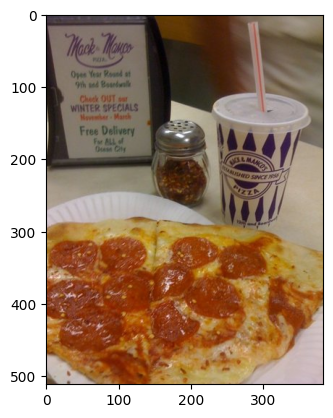

In [ ]:
from PIL import Image
im = Image.open(i)
print(f'Original size : {im.size}')
resize_im = im.resize(size=(224, 224))
print(f'Resized image size : {resize_im.size}')

plt.imshow(im)

In [ ]:
from timeit import default_timer as timer
import PIL
from pathlib import Path
from typing import List, Dict
from tqdm.auto import tqdm

def pred_and_store(test_image_paths : List[Path],
                   class_names : List[str],
                   transform : torchvision.transforms,
                   model : torch.nn.Module,
                   device : torch.device = device):
  pred_list = []

  for test_image_path in tqdm(test_image_paths):
    pred_dict = {}

    pred_dict["image_path"] = test_image_path

    class_name = test_image_path.parent.stem #here u can use anyone to get class name
    #class_name = str(test_image_path).split('/')[-2]

    pred_dict["class_name"] = class_name

    start_time = timer()

    image = Image.open(test_image_path)

    transformed_image = transform(image).unsqueeze(0).to(device)

    model.to(device)
    model.eval()

    with torch.inference_mode():

      pred_logit = model(transformed_image)

      pred_prob = torch.softmax(pred_logit, dim=1)

      pred_label = torch.argmax(pred_prob, dim=1)

      pred_class = class_names[pred_label.cpu()]

      pred_dict['pred_prob'] = round(pred_prob.unsqueeze(dim=0).max().cpu().item(), 4)

      pred_dict['pred_class'] = pred_class

      end_time = timer()

      pred_dict['time_for_pred'] =  round(end_time - start_time, 4)

    pred_dict['correct'] = class_name == pred_class

    pred_list.append(pred_dict)

  return pred_list

### 5.2 Making and timing predictions with EffNetB1

In [ ]:
# Make predictions across test dataset with EffNetB2
effnetb1_test_pred_dicts = pred_and_store(test_image_paths = test_data_paths,
                                          class_names = class_names,
                                          transform = effnetb1_transforms,
                                          model = effnetb1,
                                          device = "cpu") # make predictions on CPU

  0%|          | 0/150 [00:00<?, ?it/s]

In [ ]:
effnetb1_test_pred_dicts[:1]

[{'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/138961.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.6622,
  'pred_class': 'pizza',
  'time_for_pred': 0.1386,
  'correct': True}]

In [ ]:
import pandas as pd
effnetb1_test_pred_df = pd.DataFrame(effnetb1_test_pred_dicts)
effnetb1_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/pizza_steak_sushi_20_percent/test/pizza/1...,pizza,0.6622,pizza,0.1386,True
1,data/pizza_steak_sushi_20_percent/test/pizza/3...,pizza,0.9559,pizza,0.0778,True
2,data/pizza_steak_sushi_20_percent/test/pizza/4...,pizza,0.4590,pizza,0.0651,True
3,data/pizza_steak_sushi_20_percent/test/pizza/3...,pizza,0.8703,pizza,0.0867,True
4,data/pizza_steak_sushi_20_percent/test/pizza/9...,pizza,0.8747,pizza,0.0654,True


In [ ]:
len(effnetb1_test_pred_df)

150

In [ ]:
effnetb1_test_pred_df.correct.value_counts()

True     142
False      8
Name: correct, dtype: int64

In [ ]:
# Find the average time per prediction
effnetb1_average_time_per_pred = round(effnetb1_test_pred_df.time_for_pred.mean(), 4)
print(f"EffNetB1 average time per prediction: {effnetb1_average_time_per_pred} seconds")

EffNetB1 average time per prediction: 0.082 seconds


In [ ]:
# Add EffNetB2 average prediction time to stats dictionary
effnetb1_stats["time_per_pred_cpu"] = effnetb1_average_time_per_pred
effnetb1_stats

{'test_loss': 0.37245881259441377,
 'test_acc': 0.9443181818181818,
 'number_of_parameters': 6517027,
 'model_size (MB)': 25,
 'time_per_pred_cpu': 0.082}


### 5.3 Making and timing predictions with ViT

In [ ]:
# Make predictions across test dataset with EffNetB2
vit_test_pred_dicts = pred_and_store(test_image_paths = test_data_paths,
                                          class_names = class_names,
                                          transform = vit_transforms,
                                          model = vit,
                                          device = "cpu") # make predictions on CPU

  0%|          | 0/150 [00:00<?, ?it/s]

In [ ]:
vit_test_pred_dicts[:1]

[{'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/138961.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.9953,
  'pred_class': 'pizza',
  'time_for_pred': 0.8122,
  'correct': True}]

In [ ]:
import pandas as pd
vit_test_pred_df = pd.DataFrame(vit_test_pred_dicts)
vit_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/pizza_steak_sushi_20_percent/test/pizza/1...,pizza,0.9953,pizza,0.8122,True
1,data/pizza_steak_sushi_20_percent/test/pizza/3...,pizza,0.9984,pizza,0.5635,True
2,data/pizza_steak_sushi_20_percent/test/pizza/4...,pizza,0.9982,pizza,0.5403,True
3,data/pizza_steak_sushi_20_percent/test/pizza/3...,pizza,0.9990,pizza,0.6409,True
4,data/pizza_steak_sushi_20_percent/test/pizza/9...,pizza,0.9986,pizza,0.9635,True


In [ ]:
print(len(vit_test_pred_df))
vit_test_pred_df.correct.value_counts()

150


True     146
False      4
Name: correct, dtype: int64

In [ ]:
vit_average_time_per_pred = round(vit_test_pred_df.time_for_pred.mean(),4)
print(f"vit average time per prediction: {vit_average_time_per_pred} seconds")

vit average time per prediction: 0.6599 seconds


In [ ]:
# Add EffNetB2 average prediction time to stats dictionary
vit_stats["time_per_pred_cpu"] = vit_average_time_per_pred
vit_stats

{'test_loss': 0.06667962307110428,
 'test_acc': 0.972159090909091,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327,
 'time_per_pred_cpu': 0.6599}

## 6. Comparing model results, prediction times and size

In [ ]:
df = pd.DataFrame([effnetb1_stats, vit_stats])
df['model'] = ['effnetb1', 'vit']
df['test_acc'] = round(df['test_acc'] * 100, 2)
df

,test_loss,test_acc,number_of_parameters,model_size (MB),time_per_pred_cpu,model
0,0.372459,94.43,6517027,25,0.0820,effnetb1
1,0.066680,97.22,85800963,327,0.6599,vit


In [ ]:
# Compare ViT to EffNetB2 across different characteristics
pd.DataFrame(data=(df.set_index("model").loc["vit"] / df.set_index("model").loc["effnetb1"]), # divide ViT statistics by EffNetB2 statistics
             columns=["ViT to EffNetB2 ratios"]).T

,test_loss,test_acc,number_of_parameters,model_size (MB),time_per_pred_cpu
ViT to EffNetB2 ratios,0.179025,1.029546,13.16566,13.08,8.047561


### 6.1 Visualizing the speed vs. performance tradeoff

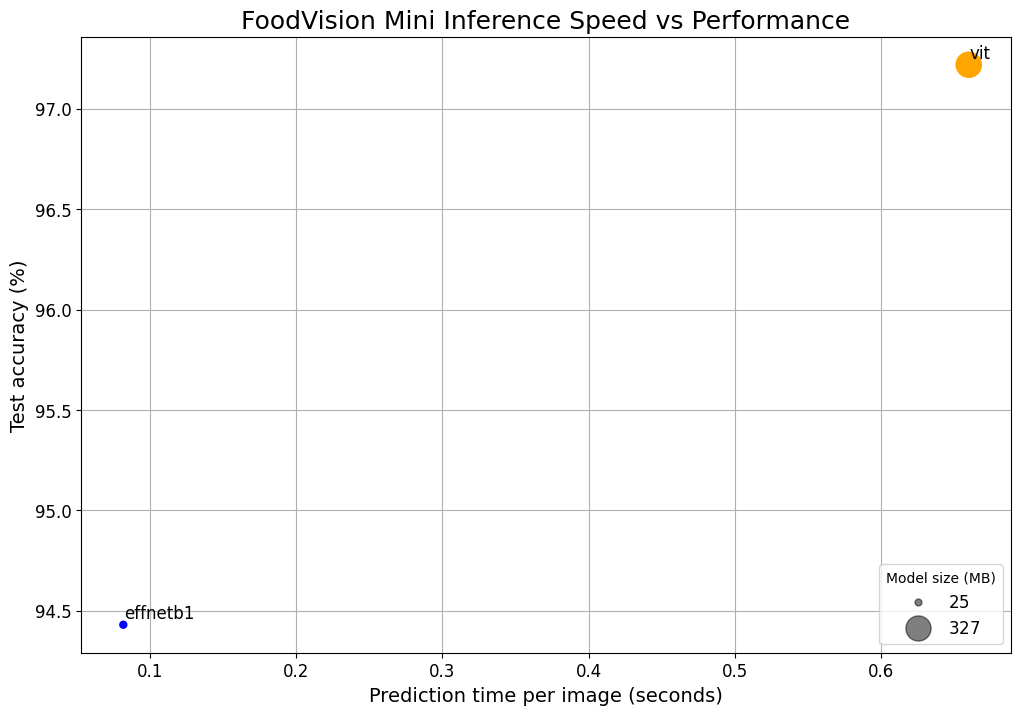

In [ ]:
# 1. Create a plot from model comparison DataFrame
fig, ax = plt.subplots(figsize=(12, 8))
scatter = ax.scatter(data=df,
                     x="time_per_pred_cpu",
                     y="test_acc",
                     c=["blue", "orange"], # what colours to use?
                     s="model_size (MB)") # size the dots by the model sizes

# 2. Add titles, labels and customize fontsize for aesthetics
ax.set_title("FoodVision Mini Inference Speed vs Performance", fontsize=18)
ax.set_xlabel("Prediction time per image (seconds)", fontsize=14)
ax.set_ylabel("Test accuracy (%)", fontsize=14)
ax.tick_params(axis='both', labelsize=12)
ax.grid(True)

# 3. Annotate with model names
for index, row in df.iterrows():
    ax.annotate(text=row["model"], # note: depending on your version of Matplotlib, you may need to use "s=..." or "text=...", see: https://github.com/faustomorales/keras-ocr/issues/183#issuecomment-977733270
                xy=(row["time_per_pred_cpu"]+0.0006, row["test_acc"]+0.03),
                size=12)

# 4. Create a legend based on model sizes
handles, labels = scatter.legend_elements(prop="sizes", alpha=0.5)
model_size_legend = ax.legend(handles,
                              labels,
                              loc="lower right",
                              title="Model size (MB)",
                              fontsize=12)

# Save the figure
plt.savefig("models/09-foodvision-mini-inference-speed-vs-performance.jpg")

# Show the figure
plt.show()

## 7. Bringing FoodVision Mini to life by creating a Gradio demo

In [ ]:
# Import/install Gradio
try:
    import gradio as gr
except:
    !pip install -q gradio
    import gradio as gr

print(f"Gradio version: {gr.__version__}")

Gradio version: 3.45.0


In [ ]:
#!pip install -q gradio==3.45.0

### 7.2 Creating a function to map our inputs and outputs

In [ ]:
# Put EffNetB2 on CPU
effnetb1.to("cpu")

# Check the device
next(iter(effnetb1.parameters())).device

device(type='cpu')

In [ ]:
from typing import Tuple, Dict

def predict(img) -> Tuple[Dict, float]:
    """Transforms and performs a prediction on img and returns prediction and time taken.
    """
    # Start the timer
    start_time = timer()

    # Transform the target image and add a batch dimension
    img = effnetb1_transforms(img).unsqueeze(0)

    # Put model into evaluation mode and turn on inference mode
    effnetb1.eval()
    with torch.inference_mode():
        # Pass the transformed image through the model and turn the prediction logits into prediction probabilities
        pred_probs = torch.softmax(effnetb1(img), dim=1)
        #print(pred_probs[0])

    # Create a prediction label and prediction probability dictionary for each prediction class (this is the required format for Gradio's output parameter)
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}
    #print(float(pred_probs[0][i]))
    # Calculate the prediction time
    pred_time = round(timer() - start_time, 5)

    # Return the prediction dictionary and prediction time
    return pred_labels_and_probs, pred_time

In [ ]:
import random
from PIL import Image

# Get a list of all test image filepaths
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))

# Randomly select a test image path
random_image_path = random.sample(test_data_paths, k=1)[0]

# Open the target image
image = Image.open(random_image_path)
print(f"[INFO] Predicting on image at path: {random_image_path}\n")

# Predict on the target image and print out the outputs
pred_dict, pred_time = predict(img=image)
print(f"Prediction label and probability dictionary: \n{pred_dict}")
print(f"Prediction time: {pred_time} seconds")

[INFO] Predicting on image at path: data/pizza_steak_sushi_20_percent/test/sushi/720302.jpg

Prediction label and probability dictionary: 
{'pizza': 0.20446468889713287, 'steak': 0.2300928235054016, 'sushi': 0.5654424428939819}
Prediction time: 0.08074 seconds


### 7.3 Creating a list of example images

In [ ]:
exmaple_paths = [[str(path)] for path in random.sample(test_data_paths, k=3)]
exmaple_paths

[['data/pizza_steak_sushi_20_percent/test/steak/48208.jpg'],
 ['data/pizza_steak_sushi_20_percent/test/sushi/3834718.jpg'],
 ['data/pizza_steak_sushi_20_percent/test/pizza/833711.jpg']]

### 7.4 Building a Gradio interface

In [ ]:
import gradio as gr

# Create title, description and article strings
title = "FoodVision Mini 🍕🥩🍣"
description = "An EfficientNetB1 feature extractor computer vision model to classify images of food as pizza, steak or sushi."
article = "Created at [09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/)."

# Create the Gradio demo
demo = gr.Interface(fn=predict, # mapping function from input to output
                    inputs=gr.Image(type="pil"), # what are the inputs?
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"), # what are the outputs?
                             gr.Number(label="Prediction time (s)")], # our fn has two outputs, therefore we have two outputs
                    examples=exmaple_paths,
                    title=title,
                    description=description,
                    article=article)

# Launch the demo!
demo.launch(debug=False, # print errors locally?
            share=True) # generate a publically shareable URL?

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://d16695f466791a5f14.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


## 8. Turning our FoodVision Mini Gradio Demo into a

```
demos/
└── foodvision_mini/
    ├── 09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth
    ├── app.py
    ├── examples/
    │   ├── example_1.jpg
    │   ├── example_2.jpg
    │   └── example_3.jpg
    ├── model.py
    └── requirements.txt
```

Where:

* 09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth is our trained PyTorch model file.

* app.py contains our Gradio app (similar to the code that launched the app).

  * Note: app.py is the default filename used for Hugging Face Spaces, if you deploy your app there, Spaces will by default look for a file called app.py to run. This is changable in settings.

examples/ contains example images to use with our Gradio app.

* model.py contains the model defintion as well as any transforms assosciated with the model.

* requirements.txt contains the dependencies to run our app such as torch, torchvision and gradio.

In [ ]:
import os
import shutil
from pathlib import Path
demo_path = Path('demo/foodvision_mini/')

if demo_path.exists():
  shutil.rmtree(demo_path)
  demo_path.mkdir(parents=True, exist_ok=True)
  #os.makedirs(demo_path, exist_ok=True) # This also performs same operation
else:
  demo_path.mkdir(parents=True, exist_ok=True)

In [ ]:
#!rm -rf dmo
demo_path

PosixPath('demo/foodvision_mini')

In [ ]:
!ls demo/foodvision_mini/

In [ ]:
import shutil

examples_path = demo_path / 'examples'
examples_path.mkdir(parents=True, exist_ok=True)

foodvision_mini_examples = [Path('data/pizza_steak_sushi_20_percent/test/sushi/592799.jpg'),
                            Path('data/pizza_steak_sushi_20_percent/test/steak/3622237.jpg'),
                            Path('data/pizza_steak_sushi_20_percent/test/pizza/2582289.jpg')]

for example in foodvision_mini_examples:
  #print(example.name)

  destination = examples_path / example.name

  print(f"[INFO] Copying {example} to {destination}")
  shutil.copy2(example, destination)



[INFO] Copying data/pizza_steak_sushi_20_percent/test/sushi/592799.jpg to demo/foodvision_mini/examples/592799.jpg
[INFO] Copying data/pizza_steak_sushi_20_percent/test/steak/3622237.jpg to demo/foodvision_mini/examples/3622237.jpg
[INFO] Copying data/pizza_steak_sushi_20_percent/test/pizza/2582289.jpg to demo/foodvision_mini/examples/2582289.jpg


In [ ]:
os.listdir(examples_path)

['592799.jpg', '3622237.jpg', '2582289.jpg']

In [ ]:
examples_list = [['examples/' + example] for example in os.listdir(examples_path)]
examples_list

[['examples/592799.jpg'], ['examples/3622237.jpg'], ['examples/2582289.jpg']]

In [ ]:
import shutil

effnetb1_foodvision_mini_model_path = 'models/09_pretrained_effnetb1_feature_extractor_pizza_steak_sushi_20_percent.pth'
effnetb1_foodvision_mini_model_path_destination = demo_path / effnetb1_foodvision_mini_model_path.split('/')[1]

try:
  print(f"[INFO] Attempting to move {effnetb1_foodvision_mini_model_path} to {effnetb1_foodvision_mini_model_path_destination}")
  shutil.move(effnetb1_foodvision_mini_model_path, effnetb1_foodvision_mini_model_path_destination)
  print(f"[INFO] Model move complete.")

except:
  print(f"[INFO] No model found at {effnetb1_foodvision_mini_model_path}, perhaps its already been moved?")
  print(f"[INFO] Model exists at {effnetb1_foodvision_mini_model_path_destination}: {effnetb1_foodvision_mini_model_path_destination.exists()}")


[INFO] Attempting to move models/09_pretrained_effnetb1_feature_extractor_pizza_steak_sushi_20_percent.pth to demo/foodvision_mini/09_pretrained_effnetb1_feature_extractor_pizza_steak_sushi_20_percent.pth
[INFO] Model move complete.


### 8.6 Turning our EffNetB2 model into a Python script (model.py)

In [ ]:
%%writefile /content/demo/foodvision_mini/model.py

import torch
import torchvision
from torch import nn

def create_effnetb1_model(num_classes:int=3,
                          seed:int=42):
    """Creates an EfficientNetB2 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of classes in the classifier head.
            Defaults to 3.
        seed (int, optional): random seed value. Defaults to 42.

    Returns:
        model (torch.nn.Module): EffNetB2 feature extractor model.
        transforms (torchvision.transforms): EffNetB2 image transforms.
    """
    # 1, 2, 3. Create EffNetB2 pretrained weights, transforms and model

    EffNetB1_weights = torchvision.models.EfficientNet_B1_Weights.DEFAULT
    #print(EffNetB1_weights)
    transforms = EffNetB1_weights.transforms()
    model = torchvision.models.efficientnet_b1(weights= EffNetB1_weights)

    # 4. Freeze all layers in base model
    for param in model.parameters():
        param.requires_grad = False

    # 5. Change classifier head with random seed for reproducibility
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1280, out_features=num_classes),
    )

    return model, transforms

Writing /content/demo/foodvision_mini/model.py


### 8.7 Turning our FoodVision Mini Gradio app into a Python script (app.py)

1 **Imports and class names setup** - Here we'll import the various dependencies for our demo including the create_effnetb2_model() function from model.py as well as setup the different class names for our FoodVision Mini app.

2.**Model and transforms preparation** - Here we'll create an EffNetB2 model instance along with the transforms to go with it and then we'll load in the saved model weights/state_dict. When we load the model we'll also set map_location=torch.device("cpu") in torch.load() so our model gets loaded onto the CPU regardless of the device it trained on (we do this because we won't necessarily have a GPU when we deploy and we'll get an error if our model is trained on GPU but we try to deploy it to CPU without explicitly saying so).

3.**Predict function** - Gradio's gradio.Interface() takes a fn parameter to map inputs to outputs, our predict() function will be the same as the one we defined above in section 7.2: Creating a function to map our inputs and outputs, it will take in an image and then use the loaded transforms to preprocess it before using the loaded model to make a prediction on it.

Note: We'll have to create the example list on the fly via the examples parameter. We can do so by creating a list of the files inside the examples/ directory with: [["examples/" + example] for example in os.listdir("examples")].

4.**Gradio app** - This is where the main logic of our demo will live, we'll create a gradio.Interface() instance called demo to put together our inputs, predict() function and outputs. And we'll finish the script by calling demo.launch() to launch our FoodVision Mini demo!

In [ ]:
!pwd


In [ ]:
%%writefile demo/foodvision_mini/app.py
### 1. Imports and class names setup ###
import torch
import torchvision
import gradio as gr
import os
import random
from torchvision import models
from timeit import default_timer as timer
from typing import Tuple, Dict
from demo.foodvision_mini.model import create_effnetb1_model

# Setup class names
class_names = ["pizza", "steak", "sushi"]

effnetb1, effnetb1_reansforms = create_effnetb1_model(num_classes=3)

effnetb1.load_state_dict(torch.load(f='09_pretrained_effnetb1_feature_extractor_pizza_steak_sushi_20_percent.pth', map_location= torch.device('cpu')))

def predict(img) -> Tuple[Dict, float]:
    """Transforms and performs a prediction on img and returns prediction and time taken.
    """
    # Start the timer
    start_time = timer()

    # Transform the target image and add a batch dimension
    img = effnetb1_reansforms(img).unsqueeze(0)

    # Put model into evaluation mode and turn on inference mode
    effnetb1.eval()
    with torch.inference_mode():
        # Pass the transformed image through the model and turn the prediction logits into prediction probabilities
        pred_probs = torch.softmax(effnetb1(img), dim=1)
        #print(pred_probs[0])

    # Create a prediction label and prediction probability dictionary for each prediction class (this is the required format for Gradio's output parameter)
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}
    #print(float(pred_probs[0][i]))
    # Calculate the prediction time
    pred_time = round(timer() - start_time, 5)

    # Return the prediction dictionary and prediction time
    return pred_labels_and_probs, pred_time

# Create title, description and article strings
title = "FoodVision Mini 🍕🥩🍣"
description = "An EfficientNetB1 feature extractor computer vision model to classify images of food as pizza, steak or sushi."
article = "Created at [09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/)."


example_list = [["examples/"  + example] for example in os.listdir("examples")]


#Create the Gradio demo
demo = gr.Interface(fn=predict, # mapping function from input to output
                    inputs=gr.Image(type="pil"), # what are the inputs?
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"), # what are the outputs?
                             gr.Number(label="Prediction time (s)")], # our fn has two outputs, therefore we have two outputs
                    examples= example_list,
                    title=title,
                    description=description,
                    article=article)

# # # Launch the demo!
demo.launch(debug=False) # generate a publically shareable URL?

Overwriting demo/foodvision_mini/app.py


### 8.8 Creating a requirements file for FoodVision Mini (requirements.txt)

In [ ]:
print(torch.__version__)
print(torchvision.__version__)
print(gr.__version__)

2.1.0+cu121
0.16.0+cu121
3.45.0


In [ ]:
%%writefile demo/foodvision_mini/requirements.txt
torch==2.1.0
torchvision==0.16.2
gradio==3.45.0

Writing demo/foodvision_mini/requirements.txt


## 9. Deploying our FoodVision Mini app to HuggingFace Spaces

In [ ]:
!ls demo/foodvision_mini

09_pretrained_effnetb1_feature_extractor_pizza_steak_sushi_20_percent.pth  model.py
app.py									   requirements.txt
examples


In [ ]:
!pwd

/content


In [ ]:
!cd demo/foodvision_mini

In [ ]:
!pwd

/content


In [ ]:
!cd demo/foodvision_mini && zip -r ../foodvision_mini.zip * -x "*.pyc" "*.ipynb" "*__pycache__*" "*ipynb_checkpoints*"

  adding: 09_pretrained_effnetb1_feature_extractor_pizza_steak_sushi_20_percent.pth (deflated 8%)
  adding: app.py (deflated 55%)
  adding: examples/ (stored 0%)
  adding: examples/592799.jpg (deflated 1%)
  adding: examples/3622237.jpg (deflated 0%)
  adding: examples/2582289.jpg (deflated 17%)
  adding: foodvision_mini.zip (stored 0%)
  adding: model.py (deflated 56%)
  adding: requirements.txt (deflated 4%)


In [ ]:
try:
  from google.colab import files
  files.download('demo/foodvision_mini.zip')
except:
  print("Not running in Google Colab, can't use google.colab.files.download(), please manually download.")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>